In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from sympy import * 
from time import time

In [ ]:
def src_Loc(rec_pos, t_rec,c,src_pos):
    '''The function returns the difference between the position of source(guessed) and receiver location as calculated from 
    measurement of time difference of arrival with the distance calculated from position of source and receiver. We aim to 
    minimise this quantity

    rec_pos = a matrix with position of receivers stored in the following format [[x_1, y_1],[x_2,y_2]]
    t_rec  = the time of arrival as measured from data
    source_loc = the guessed source location for which the function is being evaluated
    
    '''
    
    n_rec = np.shape(rec_pos)[0]
    t_rec_rel1 = np.zeros(shape=(n_rec-1,1))   # time difference calculated wrt the value in first receiver
    
    t_rec_rel1[:] = t_rec[1:] -t_rec[0]     
    
    rec_pos_src_rel = np.zeros(shape =(n_rec-1,2)) # Calculating the relative position of recivers wrt the source
    
    rec_pos_src_rel[:] = rec_pos[1:] -src_pos*np.ones_like(rec_pos_src_rel)  # relative position of receiver 1 wrt the source
    
    rec1_pos_src_rel = rec_pos[0] -src_pos # the position of receiver one wrt the source
    
    rec_dist_src_rel = np.zeros(shape=(n_rec-1,1))
    
    rec1_dist_src_rel = np.sqrt(rec1_pos_src_rel[0]**2 + rec1_pos_src_rel[1]**2)
    
    rec_dist_src_rel[:] = np.sqrt(rec_pos_src_rel[:,0]**2 + rec_pos_src_rel[:,1]**2).reshape(n_rec-1,1)
    
    delta_r = t_rec_rel1*c
    
    error = np.zeros(shape =(n_rec-1,1))   # defing the error to be minimized
    error[:] = delta_r[:] - (rec_dist_src_rel[:]-rec1_dist_src_rel)   
    
    error_to_min =np.dot(error.T,error) # Getting a single value instead of an array
    
    return error_to_min
        

In [ ]:
# Testing out with 101 receivers placed in a line

rec_pos_act= np.zeros(shape =(9,2))
rec_pos_act_4= np.zeros(shape =(12,2)) # Let us say that there are 3 reeivers placed at origin
rec_pos_act[:,:] = 0
rec_pos_act_4[:,:] = 0# The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (9,2))
noise_r_2=np.random.normal(loc=0.0,scale =100,size = (9,2))
noise_r_3=np.random.normal(loc=0.0,scale =100,size = (9,2))
noise_r_4=np.random.normal(loc=0.0,scale =100,size = (12,2))
t_rec_ideal = np.zeros(shape =(9,1))
t_rec_ideal_4 = np.zeros(shape =(12,1))# ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r
rec_pos_mes_2= rec_pos_act +noise_r_2
rec_pos_mes_4= rec_pos_act_4+noise_r_4
t_rec_ideal[0:9] = np.sqrt((rec_pos_mes[0:9,1]-300)**2 + (rec_pos_mes[0:9,0]-300)**2).reshape(9,1)
t_rec_ideal_4[0:12] = np.sqrt((rec_pos_mes_4[0:12,1]-400)**2 + (rec_pos_mes_4[0:12,0]-400)**2).reshape(12,1)
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (9,1))
noise_t_4 = np.random.normal(loc=0.0,scale =0.2,size = (12,1))
t_Rec_real = t_rec_ideal + noise_t
t_Rec_real_4 = t_rec_ideal_4 + noise_t_4

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 

In [ ]:
noise_r_3=np.random.normal(loc=0.0,scale =100,size = (9,2))
noise_r_3

1628940232.5101516
1628940252.2150333
[[-112.12121212 -112.12121212]
 [-768.68686869 -223.23232323]
 [-102.02020202 -102.02020202]
 [-112.12121212 -112.12121212]
 [ -61.61616162 -192.92929293]
 [  39.39393939 -485.85858586]
 [-687.87878788 -697.97979798]
 [ -91.91919192  -81.81818182]
 [-112.12121212 -112.12121212]
 [-112.12121212 -112.12121212]
 [-102.02020202 -102.02020202]
 [-112.12121212 -112.12121212]
 [-112.12121212 -112.12121212]
 [-112.12121212 -112.12121212]
 [-102.02020202 -102.02020202]
 [-112.12121212 -112.12121212]
 [-768.68686869 -223.23232323]
 [-102.02020202 -102.02020202]
 [-112.12121212 -112.12121212]
 [-112.12121212 -112.12121212]
 [-112.12121212 -112.12121212]
 [-102.02020202 -102.02020202]
 [-112.12121212 -112.12121212]
 [-102.02020202 -102.02020202]
 [-102.02020202 -102.02020202]
 [-102.02020202 -102.02020202]
 [-102.02020202 -102.02020202]
 [-122.22222222 -132.32323232]
 [-102.02020202 -102.02020202]
 [-112.12121212 -112.12121212]
 [-112.12121212 -112.12121212]
 

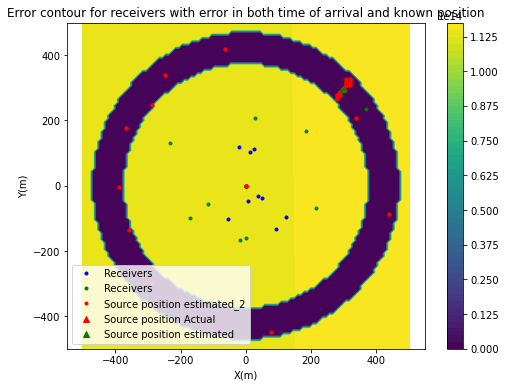

In [31]:
noise_r_3=np.random.normal(loc=0.0,scale =100,size = (9,2))
x,y =np.mgrid[-500:500:100j,-500:500:100j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(100,100)) # To store the values at various points
error2 = np.zeros(shape=(1000,1000)) 
rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:] + noise_r_3[:]  # Can modify later if required
rec_pos_mes_2[:]=rec_pos_mes_2[:]+ noise_r_3[:]
spos1=[]
spos2=[]
spos=np.zeros(shape =(164,2))
t_avg =np.mean(t_Rec_real)
rad_domain = np.sqrt(x**2 + y**2) # radius from the origin of each point in domain
r_avg = t_avg*c
n=0
t=0
print(time())
for m in range(8):
    for l in range (m,9):
        for k in range(l,9):
                    if(k!=m or k!=l):
                        for i in range(100):
                             for j in range(100):
                                if rad_domain[i,j] > r_avg  - 50  and  rad_domain[i,j] < r_avg  + 50:
                                    error[i,j] = src_Loc(rec_pos=np.array([rec_pos_mes[m],rec_pos_mes[l],rec_pos_mes[k]]),t_rec=np.array([t_Rec_real[m],t_Rec_real[l],t_Rec_real[k]]),c=c,src_pos=np.array([x[i,j],y[i,j]]))
                                else:
                                    error[i,j] = np.max(error)+1e8    
                        n+=1
                        spos[n-1,0]=x[np.where(error == np.min(error))][0]
                        spos[n-1,1]=y[np.where(error == np.min(error))][0]
for t in range(100):
        for s in range(100):
            if rad_domain[i,j] > r_avg  - 50  and  rad_domain[i,j] < r_avg  + 50:
                error[i,j] = src_Loc(rec_pos=rec_pos_mes,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
            else:
                error[i,j] = np.max(error)+1e8 

print(time())
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(rec_pos_mes_2[:,0],rec_pos_mes_2[:,1],'g.',label='Receivers')
plt.plot(spos[:,0],spos[:,1],'r.',label='Source position estimated_2')
plt.plot(300,300,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')
spos[:,0]=spos[:,0]-400
spos[:,1]=spos[:,1]-400
print(spos)              


In [17]:
spos1=np.abs(spos)

In [18]:
noise_r_4=np.random.normal(loc=0.0,scale =100,size = (12,2))
x,y =np.mgrid[-500:500:100j,-500:500:100j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(100,100)) # To store the values at various points
error2 = np.zeros(shape=(1000,1000)) 
rec_pos_modified_4 = np.zeros_like(rec_pos_act_4)
rec_pos_modified_4[:] = rec_pos_act_4[:] + noise_r_4[:]  # Can modify later if required
rec_pos_mes_4[:]=rec_pos_mes_4_2[:]+ noise_r_4[:]

spos1=[]
spos2=[]
spos=np.zeros(shape =(352,2))
t_avg_4 =np.mean(t_Rec_real_4)
rad_domain = np.sqrt(x**2 + y**2) # radius from the origin of each point in domain
r_avg = t_avg*c
n=0
t=0
for m in range(11):
    for l in range (m,12):
        for k in range(l,12):
                    if(k!=m or k!=l):
                        for i in range(100):
                             for j in range(100):
                                if rad_domain[i,j] > r_avg  - 50  and  rad_domain[i,j] < r_avg  + 50:
                                    error[i,j] = src_Loc(rec_pos=np.array([rec_pos_modified_4[m],rec_pos_modified_4[l],rec_pos_modified_4[k]]),t_rec=np.array([t_Rec_real_4[m],t_Rec_real_4[l],t_Rec_real_4[k]]),c=c,src_pos=np.array([x[i,j],y[i,j]]))
                                else:
                                    error[i,j] = np.max(error)+1e8    
                        n+=1
                    
                  
                        spos[n-1,0]=x[np.where(error == np.min(error))][0]
                        spos[n-1,1]=y[np.where(error == np.min(error))][0]
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes_4_2[:,0],rec_pos_mes_4_2[:,1],'b.',label='actual Receivers')
plt.plot(rec_pos_mes_4[:,0],rec_pos_mes_4[:,1],'g.',label='Receivers')
plt.plot(spos[:,0],spos[:,1],'r.',label='Source position estimated_2')
plt.plot(300,300,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')
spos[:,0]=spos[:,0]-400
spos[:,1]=spos[:,1]-400
print(spos)

NameError: name 'rec_pos_mes_4_2' is not defined

In [18]:
def standard_deviation(spos):
    X=np.mean(spos[:,0])
    Y=np.mean(spos[:,1])
    var_x=0
    var_y=0
    for i in range(len(spos[:,0])):
        var_x+=(spos[i,0]-X)**2/len(spos[:,0])
        var_y+=(spos[i,1]-Y)**2/len(spos[:,0])
    std_div=[np.sqrt(var_x)]+[np.sqrt(var_y)]
    return std_div

In [19]:
rec_pos_mes_2=np.zeros_like(rec_pos_act)

rec_pos_mes_2= rec_pos_act +noise_r_2

In [ ]:
noise_r_3=np.random.normal(loc=0.0,scale =50,size = (9,2))
x,y =np.mgrid[-500:500:100j,-500:500:100j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(100,100)) # To store the values at various points
error2 = np.zeros(shape=(100,100)) 
rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:] + noise_r_3[:]  # Can modify later if required
rec_pos_mes_2[:]=rec_pos_mes_2[:]+ noise_r_3[:]
spos1=[]
spos2=[]
spos=np.zeros(shape =(28,2))
t_avg =np.mean(t_Rec_real)
rad_domain = np.sqrt(x**2 + y**2) # radius from the origin of each point in domain
r_avg = t_avg*c
rec_pos_modified[0]=[-50,-50]
o=0
variance=np.zeros(shape=(100,100))
rec_pos_assumed_x=np.zeros(shape=(100,100))
rec_pos_assumed_y=np.zeros(shape=(100,100))
for t in range(100):
    for s in range(100):
        if rad_domain[t,s] > r_avg  - 50  and  rad_domain[t,s] < r_avg  + 50:
            error2[t,s] = src_Loc(rec_pos=rec_pos_mes,t_rec=t_Rec_real,c=c,src_pos=np.array([x[t,s],y[t,s]]))
        else:
            error2[t,s] = np.max(error)+1e8
for z in range(100):
    rec_pos_modified[0,0]+=1
    rec_pos_modified[0,1]=0
    for t in range(100):
        n=0
        spos=np.zeros(shape =(29,2))
        rec_pos_modified[0,1]+=1
        rec_pos_assumed_x[z,t]=rec_pos_modified[0,0]
        rec_pos_assumed_y[z,t]=rec_pos_modified[0,1]
        for l in range (1,9):
             for k in range(l,9):
                if( k!=l):
                    for i in range(100):
                         for j in range(100):
                                if rad_domain[i,j] > r_avg  - 50  and  rad_domain[i,j] < r_avg  + 50:
                                     error[i,j] = src_Loc(rec_pos=np.array([rec_pos_modified[o],rec_pos_mes_2[l],rec_pos_mes_2[k]]),t_rec=np.array([t_Rec_real[o],t_Rec_real[l],t_Rec_real[k]]),c=c,src_pos=np.array([x[i,j],y[i,j]]))
                                else:
                                     error[i,j] = np.max(error)+1e8
                    n+=1
                    spos[n-1,0]=x[np.where(error == np.min(error))][0]
                    spos[n-1,1]=y[np.where(error == np.min(error))][0]
        variance[z,t]=standard_deviation(spos)[0]
rec_pos_modified[0,0]=rec_pos_assumed_x[np.where(variance==np.min(variance))][0]
rec_pos_modified[0,1]=rec_pos_assumed_y[np.where(variance==np.min(variance))][0]
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
error3=rec_pos_modified[0]-rec_pos_mes[0]
print(error3)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(rec_pos_modified[:,0],rec_pos_modified[:,1],'g.',label='Receivers_estimated')
plt.plot(spos[:,0],spos[:,1],'r.',label='Source position estimated_2')
plt.plot(300,300,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')    

    
    
    

                          

               


In [ ]:
err



In [ ]:
error[0,0]

In [33]:
1628940252.2150333-1628940232.5101516

19.70488166809082

In [34]:
19.70488166809082/9

2.1894312964545355

In [ ]:
2.1894312964545355*10000